# Rank-Order distance

In [71]:
import numpy as np
from sklearn.metrics.pairwise import pairwise_distances
import matplotlib
import matplotlib.pyplot as plt
from collections import defaultdict
import pickle as pkl

In [6]:
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (20, 10)

Clusters can be represented as dicts
C = {cluster_idx: [idx_1, idx_2, ...]}

For merging, we can combine clusters by combining lists and then adding a new cluster_idx
merge(C_i, C_j, dC, cluster_cnt) --> dC[cluster_cnt+1] = dC[C_i] + dC[C_j], wipe out cluster_idxs 
corresponding to C_i, C_j

In [90]:
class RankOrderClusterer():
    
    def __init__(self, X, t=14, K=9):
        self.m = X.shape[0]
        assert self.m > 2 # need more than two data points!
        self.t = t
        self.K = min(K, self.m-1) # if K > max NN, set K = max NN
        self.load_data(X)
        self.merge_data = defaultdict(list)
    
    def load_data(self, X):
        # Loads in the data and initializes variables 
        
        # order lists in array and dict-forms for individual data points;
        # these don't need to be saved off if we have D, but keep it around
        # if we ever need to query individual distances
        self.O = np.zeros((self.m, self.m-1))
        sorted_sample_idxs = np.argsort(pairwise_distances(X)).astype(np.int32)
        for sample_idx, order_list in enumerate(sorted_sample_idxs):
            self.O[sample_idx] = np.array([idx for idx in order_list if idx != sample_idx])
        
        # converts a list of order lists into a dict of dicts,
        # with format {data_sample_idx: {nn_idx: order_list_idx}}
        # e.g. if a data sample indexed 5 has an order list [3,2,4,1],
        # this would return {5: {3:1, 2:2, 4:3, 1:4}}
        self.dO = {}
        for idx, order_list in enumerate(self.O):
            self.dO[idx] = {v:(idx+1) for idx, v in enumerate(order_list)}
                                          
        # Creates an m x m matrix of asymmetric rank-order pairwise distances                               
        self.D = np.zeros((self.m, self.m))
        for a in range(self.m):
            for b in range(self.m):
                if a != b:
                    self.D[a,b] = self.compute_D_a_b(a, b)
        
        # order lists in array and dict-forms at the cluster-level
        self.C = {idx: [idx] for idx in range(self.m)} # each data point is a cluster
        self.cO = self.O
        self.dcO = self.dO
        
        # for singletons
        self.first_time = True
               
    def _update_cluster_order_lists(self):
        # generates cluster-level order lists based on absolute cluster distances
        k = len(self.C)
        self.cO = np.zeros((k, k-1))
        pairwise_d_Ci_Cj = np.zeros((k,k))
        for i in range(k):
            for j in range(k):
                if i != j:
                    pairwise_d_Ci_Cj[i, j] = self.compute_d_Ci_Cj(i,j)
        sorted_cluster_idxs = np.argsort(pairwise_d_Ci_Cj)
        for cluster_idx, order_list in enumerate(sorted_cluster_idxs):
            self.cO[cluster_idx] = np.array([idx for idx in order_list if idx != cluster_idx])

    def _convert_cluster_order_lists_to_dicts(self):
        # converts a list of order lists into a dict of dicts,
        # with format {data_sample_idx: {nn_idx: order_list_idx}}
        # e.g. if a data sample indexed 5 has an order list [3,2,4,1],
        # this would return {5: {3:1, 2:2, 4:3, 1:4}}
        self.dcO = {}
        for idx, order_list in enumerate(self.cO):
            self.dcO[idx] = {v:(idx+1) for idx, v in enumerate(order_list)}

    def compute_D_a_b(self, a, b):
        # D(a, b) (1) - asymmetric rank-order distance
        idx = 0
        a_ = self.O[a][idx]
        D_a_b = 0
        while a_ != b:
            D_a_b += self.dO[b][a_]
            idx += 1
            a_ = self.O[a][idx]
        return D_a_b
    
    def compute_D_R_a_b(self, a, b):
        # D^R(a, b) (2) = - normalized, symmetric rank-order 
        # distance between data samples
        O_ab = self.dO[a][b]
        O_ba = self.dO[b][a]
        assert O_ab > 0
        assert O_ba > 0
        return 1.*(self.D[a,b] + self.D[b,a]) / min(O_ab, O_ba)
    
    def compute_d_Ci_Cj(self, i, j):
        # d(C_i, C_j) (3) - defined simply to be the minimum
        # rank-order pairwise distance among the cluster members
        d_Ci_Cj = np.inf
        C_i = self.C[i]
        C_j = self.C[j]
        for a in C_i:
            for b in C_j:
                if self.D[a,b] < d_Ci_Cj:
                    d_Ci_Cj = self.D[a, b]
        return d_Ci_Cj
    
    def compute_D_Ci_Cj(self, i, j):
        # D(Ci, Cj) (*not explictly in paper*) - the asymmetric rank-order 
        # distance at the cluster-level
        idx = 0
        i_ = self.cO[i][idx]        
        D_Ci_Cj = 0
        while i_ != j:
            D_Ci_Cj += self.dcO[j][i_]
            idx += 1
            i_ = self.cO[i][idx]
        return D_Ci_Cj

    def compute_D_R_Ci_Cj(self, i, j):
        # D^R(C_i, C_j) (4) - symmetric rank-order distance 
        # at the cluster-level
        D_ij = self.compute_D_Ci_Cj(i, j)
        D_ji = self.compute_D_Ci_Cj(j, i)
        O_ij = self.dcO[i][j]
        O_ji = self.dcO[j][i]
        assert O_ij > 0
        assert O_ji > 0
        D_R_Ci_Cj = 1.*(D_ij + D_ji)/ min(O_ij, O_ji)
        return D_R_Ci_Cj
    
    def compute_D_N_Ci_Cj(self, i, j):
        # D^N(C_i, C_j) (5) - cluster-level normalized distance
        # Compute the average rank-order distance for all members of
        # both clusters
        C_i_U_C_j = self.C[i] + self.C[j]
        avg_K_dist = [None]*len(C_i_U_C_j)
        for idx, a in enumerate(C_i_U_C_j):
            avg_K_dist[idx] = np.mean([self.D[a,k] for k in self.O[a][:self.K]])
        phi_Ci_Cj =  np.mean(avg_K_dist)
        D_N_Ci_Cj = 1./phi_Ci_Cj*self.compute_d_Ci_Cj(i, j)
        return D_N_Ci_Cj
    
    def _update_clusters(self, merged_sets):
        # update the cluster state
        def update_cluster(merged_set, cluster_cnt):
            data_idxs = []
            for cluster_idx in merged_set:
                data_idxs += self.C.pop(cluster_idx)
            self.C[cluster_cnt] = data_idxs

        # update all clusters
        curr_cluster_cnt = len(self.C) + 1
        for merged_set in merged_sets:
            update_cluster(merged_set, curr_cluster_cnt)
            curr_cluster_cnt += 1
        
        # re-index clusters
        new_C = {}
        for new_idx, (old_idx, _) in enumerate(self.C.iteritems()):
            new_C[new_idx] = self.C[old_idx]
        self.C = new_C
        self._update_cluster_order_lists()
        self._convert_cluster_order_lists_to_dicts()
        
    def _transitive_merge(self, merge_candidates):
        # takes pairs of cluster indices to be merged and 
        # transitively merges
        def indices_dict(merge_candidates):
            d = defaultdict(list)
            for i,(a,b) in enumerate(merge_candidates):
                d[a].append(i)
                d[b].append(i)
            return d

        def disjoint_indices(merge_candidates):
            d = indices_dict(merge_candidates)
            sets = []
            while len(d):
                que = set(d.popitem()[1])
                ind = set()
                while len(que):
                    ind |= que 
                    que = set([y for i in que 
                                 for x in merge_candidates[i] 
                                 for y in d.pop(x, [])]) - ind
                sets += [ind]
            return sets
        
        merged_sets = [set([x for i in s for x in merge_candidates[i]]) \
                       for s in disjoint_indices(merge_candidates)]
        
        self._update_clusters(merged_sets)
        
        # since every point must be assigned a cluster, this should never 
        # change
        assert np.sum([len(v) for _,v in self.C.iteritems()]) == self.m
        
    def perform_clustering(self):
        # continue to merge until there are no merge candidates left
        merge_cnt = 1
        while True:
            num_clusters = len(self.C)
            merge_candidates = []
            # go through all pairs of clusters...
            for i in range(num_clusters-1):
                for j in range(i+1, num_clusters):
                    
                    # Compute cluster-level Rank-Order and normalized distances
                    D_R_Ci_Cj = self.compute_D_R_Ci_Cj(i,j)
                    D_N_Ci_Cj = self.compute_D_N_Ci_Cj(i,j)
                    
                    # store some info for analysis purposes
                    self.merge_data['Merge %i'%(merge_cnt)].append((D_R_Ci_Cj, D_N_Ci_Cj))
                    
                    # if any cluster pairs meet merge conditions...
                    if D_R_Ci_Cj < self.t and D_N_Ci_Cj < 1.:
                        merge_candidates.append((i,j))
                    
            if len(merge_candidates) == 0:
                break
            self._transitive_merge(merge_candidates)
            merge_cnt += 1

# Playing with real data

In [91]:
user_id = 1946418
openface_dir = '/Users/babasarala/Desktop/face_clustering/openface_cnn_codes'
cnn_codes_filepath = '%s/%i_cnn_codes.p'%(openface_dir, user_id)
img_urls, X = pkl.load(open(cnn_codes_filepath, 'rb'))

In [103]:
roc_ = RankOrderClusterer(X, t=5, K=9)
roc_.perform_clustering()

/usr/local/lib/python2.7/site-packages/IPython/kernel/__main__.py:130: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [104]:
len(roc_.C)

79

(array([  2.64000000e+02,   5.37000000e+02,   7.48000000e+02,
          1.16500000e+03,   9.12000000e+02,   7.51000000e+02,
          7.01000000e+02,   7.45000000e+02,   1.93000000e+03,
          3.03800000e+03,   2.50700000e+03,   1.47800000e+03,
          6.27000000e+02,   2.38000000e+02,   1.29000000e+02,
          1.04000000e+02,   6.30000000e+01,   4.70000000e+01,
          4.90000000e+01,   3.10000000e+01,   3.00000000e+01,
          2.40000000e+01,   1.60000000e+01,   8.00000000e+00,
          1.80000000e+01,   1.90000000e+01,   1.40000000e+01,
          6.00000000e+00,   1.10000000e+01,   2.00000000e+00,
          6.00000000e+00,   6.00000000e+00,   5.00000000e+00,
          3.00000000e+00,   3.00000000e+00,   5.00000000e+00,
          0.00000000e+00,   4.00000000e+00,   0.00000000e+00,
          3.00000000e+00,   0.00000000e+00,   6.00000000e+00,
          3.00000000e+00,   2.00000000e+00,   0.00000000e+00,
          5.00000000e+00,   1.00000000e+00,   3.00000000e+00,
        

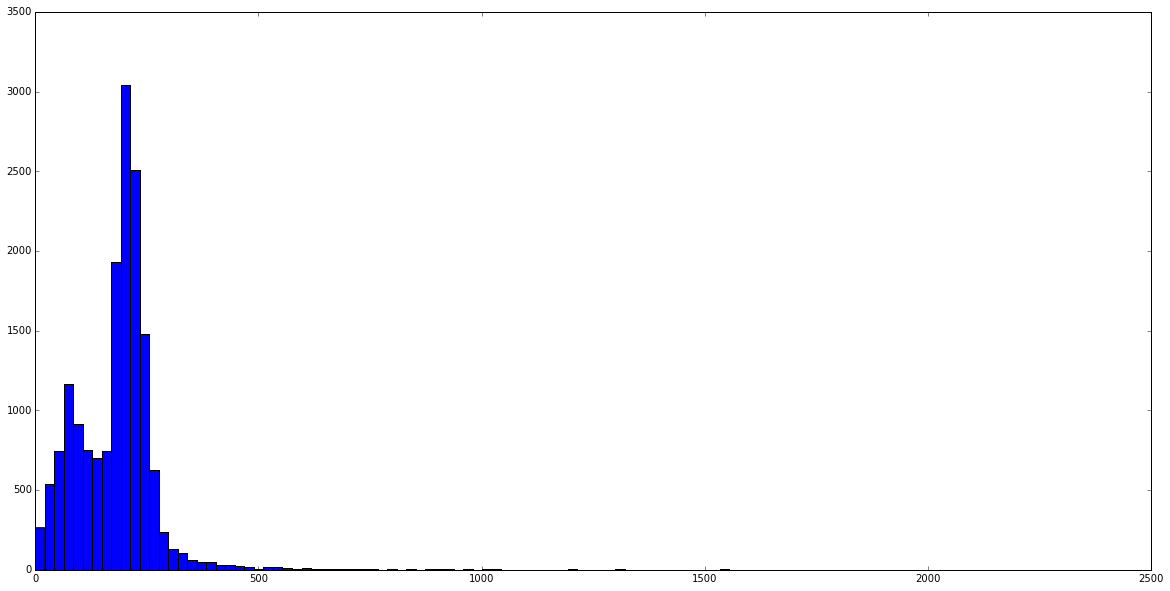

In [97]:
plt.hist([tup[0] for tup in roc_.merge_data['Merge 2']], bins=100)

In [80]:
roc_.D

array([[  0.00000000e+00,   5.47800000e+03,   8.26640000e+04, ...,
          2.37100000e+03,   3.74770000e+04,   2.45300000e+03],
       [  8.24900000e+03,   0.00000000e+00,   6.80820000e+04, ...,
          2.54300000e+03,   6.20150000e+04,   1.16800000e+03],
       [  7.48970000e+04,   6.41630000e+04,   0.00000000e+00, ...,
          8.15910000e+04,   3.64740000e+04,   7.17010000e+04],
       ..., 
       [  8.38500000e+03,   6.60100000e+03,   8.32540000e+04, ...,
          0.00000000e+00,   4.50170000e+04,   0.00000000e+00],
       [  2.71880000e+04,   6.73980000e+04,   5.74610000e+04, ...,
          5.26550000e+04,   0.00000000e+00,   4.66040000e+04],
       [  9.39600000e+03,   5.83200000e+03,   8.02500000e+04, ...,
          2.00000000e+00,   4.43280000e+04,   0.00000000e+00]])

# Playing with fake data

In [ ]:
# generate fake gaussian data
N = 100
plot_with_annotation = True
mu_1 = [-20, 80]
cov_1 = [[50, 0], [0, 50]]
mu_2 = [50, 50]
cov_2 = [[10, 0], [0, 10]]
mu_3 = [-10, -10]
cov_3 = [[70, 0], [0, 70]]
X = np.concatenate([np.random.multivariate_normal(mu_1, cov_1, N),
                    np.random.multivariate_normal(mu_2, cov_2, N),
                    np.random.multivariate_normal(mu_3, cov_3, N)])
fig, ax = plt.subplots()
ax.scatter(X[:,0], X[:, 1])
if plot_with_annotation:
    for idx, pt in enumerate(X):
        ax.annotate(idx, X[idx])

In [69]:
roc_ = RankOrderClusterer(X, t=14, K=9)

In [70]:
roc_.perform_clustering()
print len(roc_.C)

3


/usr/local/lib/python2.7/site-packages/IPython/kernel/__main__.py:129: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [67]:
roc_.C

{0: [200,
  201,
  202,
  204,
  205,
  206,
  207,
  208,
  209,
  210,
  211,
  212,
  213,
  214,
  215,
  216,
  217,
  218,
  219,
  220,
  221,
  222,
  223,
  224,
  226,
  227,
  228,
  229,
  230,
  231,
  232,
  233,
  235,
  236,
  237,
  238,
  240,
  241,
  242,
  243,
  244,
  245,
  246,
  247,
  248,
  249,
  251,
  252,
  253,
  254,
  256,
  257,
  258,
  259,
  261,
  262,
  263,
  265,
  266,
  267,
  268,
  269,
  270,
  271,
  272,
  273,
  274,
  276,
  277,
  278,
  279,
  280,
  281,
  282,
  283,
  284,
  285,
  287,
  289,
  290,
  291,
  292,
  293,
  294,
  295,
  296,
  297,
  298,
  299,
  260,
  288,
  225,
  264,
  234,
  203,
  239,
  250,
  255,
  275,
  286],
 1: [193,
  150,
  160,
  194,
  172,
  114,
  185,
  121,
  122,
  154,
  190,
  127,
  111,
  192,
  131,
  109,
  142,
  143,
  144,
  189,
  176,
  171,
  166,
  183,
  196,
  116,
  128,
  129,
  132,
  133,
  134,
  135,
  136,
  137,
  138,
  139,
  141,
  146,
  147,
  148,
  151,
  152,

# Testing

In [27]:
X_test = np.array([[0,0],[0,1],[0,2.1],[0,5],[0,6],[0,7.1]])

In [28]:
roc_test = RankOrderClusterer(X_test, t=3.0, K=3)

In [572]:
roc_test.D

array([[  0.,   0.,   1.,   7.,   8.,  10.],
       [  0.,   0.,   2.,   8.,   9.,  11.],
       [  1.,   0.,   0.,   9.,  10.,  12.],
       [ 12.,  11.,   9.,   0.,   0.,   1.],
       [ 11.,  10.,   8.,   0.,   0.,   2.],
       [ 10.,   9.,   7.,   1.,   0.,   0.]])

In [29]:
roc_test.D

array([[  0.,   0.,   1.,   7.,   8.,  10.],
       [  0.,   0.,   2.,   8.,   9.,  11.],
       [  1.,   0.,   0.,   9.,  10.,  12.],
       [ 12.,  11.,   9.,   0.,   0.,   1.],
       [ 11.,  10.,   8.,   0.,   0.,   2.],
       [ 10.,   9.,   7.,   1.,   0.,   0.]])

In [21]:
a = 0
b = 1
for a_ in roc_test.dO[a]

{0: {1.0: 1, 2.0: 2, 3.0: 3, 4.0: 4, 5.0: 5},
 1: {0.0: 1, 2.0: 2, 3.0: 3, 4.0: 4, 5.0: 5},
 2: {0.0: 2, 1.0: 1, 3.0: 3, 4.0: 4, 5.0: 5},
 3: {0.0: 5, 1.0: 4, 2.0: 3, 4.0: 1, 5.0: 2},
 4: {0.0: 5, 1.0: 4, 2.0: 3, 3.0: 1, 5.0: 2},
 5: {0.0: 5, 1.0: 4, 2.0: 3, 3.0: 2, 4.0: 1}}

In [574]:
roc_test.O

array([[ 1.,  2.,  3.,  4.,  5.],
       [ 0.,  2.,  3.,  4.,  5.],
       [ 1.,  0.,  3.,  4.,  5.],
       [ 4.,  5.,  2.,  1.,  0.],
       [ 3.,  5.,  2.,  1.,  0.],
       [ 4.,  3.,  2.,  1.,  0.]])

In [575]:
roc_test.compute_d_Ci_Cj(2,4)

10.0

In [577]:
roc_test.C

{0: [0, 1, 2], 1: [3, 4, 5]}

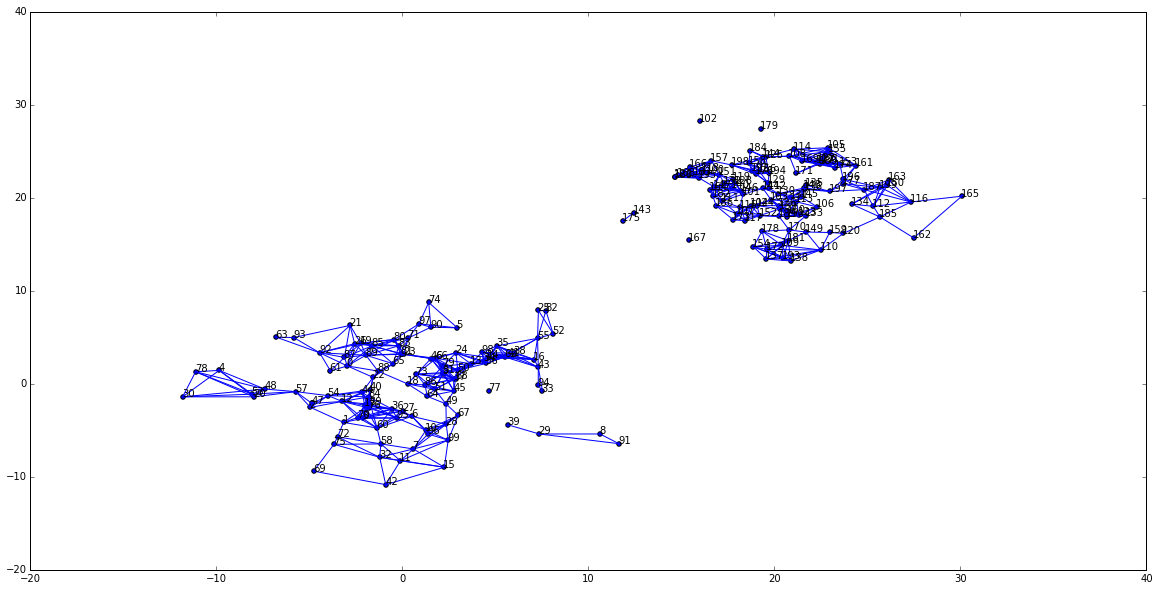

In [353]:
fig, ax = plt.subplots()
ax.scatter(X[:,0], X[:, 1])
if plot_with_annotation:
    for idx, pt in enumerate(X):
        ax.annotate(idx, X[idx])

for pts in dC:
    ax.plot([X[pts[0],0], X[pts[1],0]], [X[pts[0],1], X[pts[1],1]], 'blue')

In [311]:
cluster_ids = {}
for idx, cluster_idx in C.iteritems():
    if cluster_idx[0] not in cluster_ids:
        cluster_ids[cluster_idx[0]] = []
    cluster_ids[cluster_idx[0]].append(idx)

In [521]:
import numpy as np
np.empty((2,2))

array([[ 0.,  0.],
       [ 0.,  0.]])

In [ ]:
def perform_clustering_by_rank_order_distance(X, t=8):
    # 1. generate order lists
    O = generate_order_lists(X)
    
    # 2. for efficient look-ups, store in dicts
    dO = convert_order_lists_to_dicts(O)
    
    # 3. We need to store absolute rank-order distances between
    #    individual points, so store that away
    D = compute_absolute_rank_order_matrix(O, dO)
    
    # 4. Perform the first level of clustering 
    
    
    
    

In [115]:
O = generate_order_lists(X)
dO = convert_order_lists_to_dicts(O)
dO

{0: {1: 3, 2: 4, 3: 2, 4: 1, 5: 6, 6: 9, 7: 5, 8: 7, 9: 8},
 1: {0: 4, 2: 3, 3: 1, 4: 2, 5: 6, 6: 8, 7: 5, 8: 7, 9: 9},
 2: {0: 4, 1: 1, 3: 3, 4: 2, 5: 6, 6: 8, 7: 5, 8: 7, 9: 9},
 3: {0: 3, 1: 2, 2: 4, 4: 1, 5: 6, 6: 9, 7: 5, 8: 7, 9: 8},
 4: {0: 3, 1: 2, 2: 4, 3: 1, 5: 6, 6: 8, 7: 5, 8: 7, 9: 9},
 5: {0: 9, 1: 5, 2: 8, 3: 6, 4: 7, 6: 3, 7: 2, 8: 1, 9: 4},
 6: {0: 9, 1: 5, 2: 8, 3: 6, 4: 7, 5: 1, 7: 3, 8: 2, 9: 4},
 7: {0: 9, 1: 5, 2: 8, 3: 6, 4: 7, 5: 2, 6: 3, 8: 1, 9: 4},
 8: {0: 9, 1: 5, 2: 8, 3: 6, 4: 7, 5: 1, 6: 3, 7: 2, 9: 4},
 9: {0: 8, 1: 5, 2: 9, 3: 6, 4: 7, 5: 3, 6: 4, 7: 2, 8: 1}}

In [119]:
D = compute_absolute_rank_order_matrix(O, dO)

In [120]:
D

array([[  0.,   3.,   6.,   1.,   0.,  28.,  36.,  26.,  29.,  33.],
       [  7.,   0.,   5.,   0.,   1.,  32.,  36.,  30.,  33.,  40.],
       [  6.,   0.,   0.,   3.,   2.,  29.,  33.,  27.,  30.,  36.],
       [  4.,   2.,   7.,   0.,   0.,  31.,  39.,  29.,  32.,  35.],
       [  5.,   1.,   8.,   0.,   0.,  30.,  34.,  28.,  31.,  38.],
       [ 39.,  29.,  35.,  31.,  32.,   0.,   5.,   1.,   0.,   7.],
       [ 36.,  27.,  33.,  28.,  30.,   0.,   0.,   3.,   1.,   6.],
       [ 40.,  30.,  36.,  32.,  33.,   1.,   3.,   0.,   0.,   8.],
       [ 38.,  28.,  34.,  30.,  31.,   0.,   4.,   2.,   0.,   9.],
       [ 33.,  26.,  36.,  29.,  29.,   3.,   6.,   1.,   0.,   0.]])

In [85]:
thresh = 8
f = {}
for k, v in d.iteritems():
    if v < thresh:
        f[k] = v

In [86]:
f

{(0, 1): 3.3333333333333335,
 (0, 2): 3.0,
 (0, 3): 2.5,
 (0, 4): 5.0,
 (1, 2): 5.0,
 (1, 3): 2.0,
 (1, 4): 1.0,
 (2, 3): 3.3333333333333335,
 (2, 4): 5.0,
 (3, 4): 0.0,
 (5, 6): 5.0,
 (5, 7): 1.0,
 (5, 8): 0.0,
 (5, 9): 3.3333333333333335,
 (6, 7): 2.0,
 (6, 8): 2.5,
 (6, 9): 3.0,
 (7, 8): 2.0,
 (7, 9): 4.5}

# Playground

In [44]:
from collections import defaultdict

def indices_dict(lis):
    d = defaultdict(list)
    for i,(a,b) in enumerate(lis):
        d[a].append(i)
        d[b].append(i)
    return d

def disjoint_indices(lis):
    d = indices_dict(lis)
    sets = []
    while len(d):
        que = set(d.popitem()[1])
        ind = set()
        while len(que):
            ind |= que 
            que = set([y for i in que 
                         for x in lis[i] 
                         for y in d.pop(x, [])]) - ind
        sets += [ind]
    return sets

def disjoint_sets(lis):
    return [set([x for i in s for x in lis[i]]) for s in disjoint_indices(lis)]

In [46]:
lis = [(1,2),(2,3),(4,5),(6,7),(1,7)]
disjoint_sets(lis)

[{1, 2, 3, 6, 7}, {4, 5}]